# Boxplot of metrics from simulation analysis

In [1]:
library(ggpubr)
library(tidyverse)

Loading required package: ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## Classification

In [3]:
pred_features = 15
rfecv10 = data.table::fread('../../_m/classification_simu/rfecv_results_10_step.txt') %>% 
    select(-V1) %>% 
    pivot_longer(-c(n_features, seed, best_n, cpu_total), names_to='fold', values_to='score') %>%
    mutate(fold=str_replace(fold, 'Fold_', '')) %>% 
    group_by(seed) %>% filter(n_features %in% best_n) %>% 
    mutate(abs_err=abs(pred_features - n_features) / pred_features, 
           precision=ifelse(n_features < pred_features, n_features/n_features, pred_features/n_features), 
           model="RFE (10 step)") %>% 
    select(seed, n_features, cpu_total, score, abs_err, precision, model) %>% 
    filter(n_features < 102) # drop outliers
rfecv100 = data.table::fread('../../_m/classification_simu/rfecv_results_100_step.txt') %>% 
    select(-V1) %>% 
    pivot_longer(-c(n_features, seed, best_n, cpu_total), names_to='fold', values_to='score') %>%
    mutate(fold=str_replace(fold, 'Fold_', '')) %>% 
    group_by(seed) %>% filter(n_features %in% best_n) %>% 
    mutate(abs_err=abs(pred_features - n_features) / pred_features, 
           precision=ifelse(n_features < pred_features, n_features/n_features, pred_features/n_features),
           model="RFE (100 step)") %>% 
    select(seed, n_features, cpu_total, score, abs_err, precision, model) %>% 
    filter(n_features < 102) # drop outliers
raffe = data.table::fread('../../_m/classification_simu/raffe_results.txt') %>% 
    rename(fold=index) %>% select(-V1) %>% group_by(seed) %>% 
    mutate(abs_err=abs(pred_features - n_features) / pred_features, 
           precision=ifelse(n_features < pred_features, n_features/n_features, pred_features/n_features), 
           model="RaFFE") %>% 
    select(seed, n_features, test_nmi, cpu_total, abs_err, precision, model) %>% 
    rename(score=test_nmi)

dft = bind_rows(raffe, rfecv100, rfecv10) %>% mutate(cpu=cpu_total/60)
dft %>% head(2)

seed,n_features,score,cpu_total,abs_err,precision,model,cpu
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,18,0.8585595,153.2534,0.2,0.8333333,RaFFE,2.554224
1,21,0.6349910,153.2534,0.4,0.7142857,RaFFE,2.554224


Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


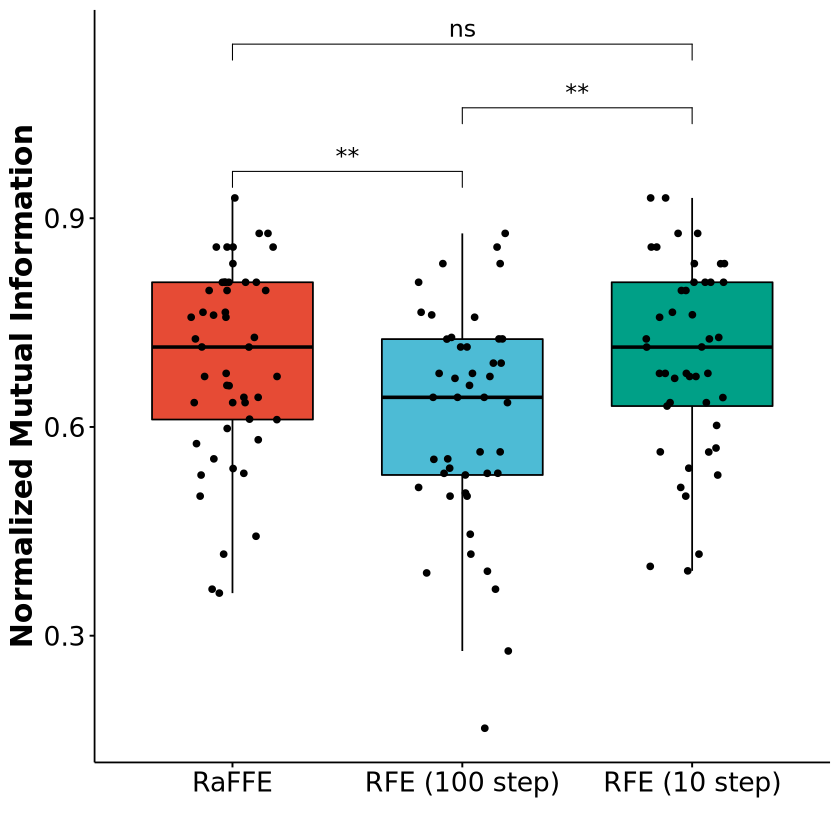

In [4]:
my_comparisons <- list( c("RaFFE", "RFE (100 step)"), 
                       c("RFE (100 step)", "RFE (10 step)"), 
                       c("RaFFE", "RFE (10 step)") )
# Add pairwise comparisons p-value
bxp_acc1 = ggboxplot(dft, x='model', y='score', ncol=1, fill="model", 
                    palette="npg", outlier.shape=NA, add='jitter', 
                    xlab='', ylab='Normalized Mutual Information', 
                    legend='') + 
        stat_compare_means(comparisons = my_comparisons, 
                           aes(label = ..p.signif..), 
                           method = "t.test", size=5) + 
        font("xylab", size = 18, face='bold') + font("xy.text", size = 16)
bxp_acc1

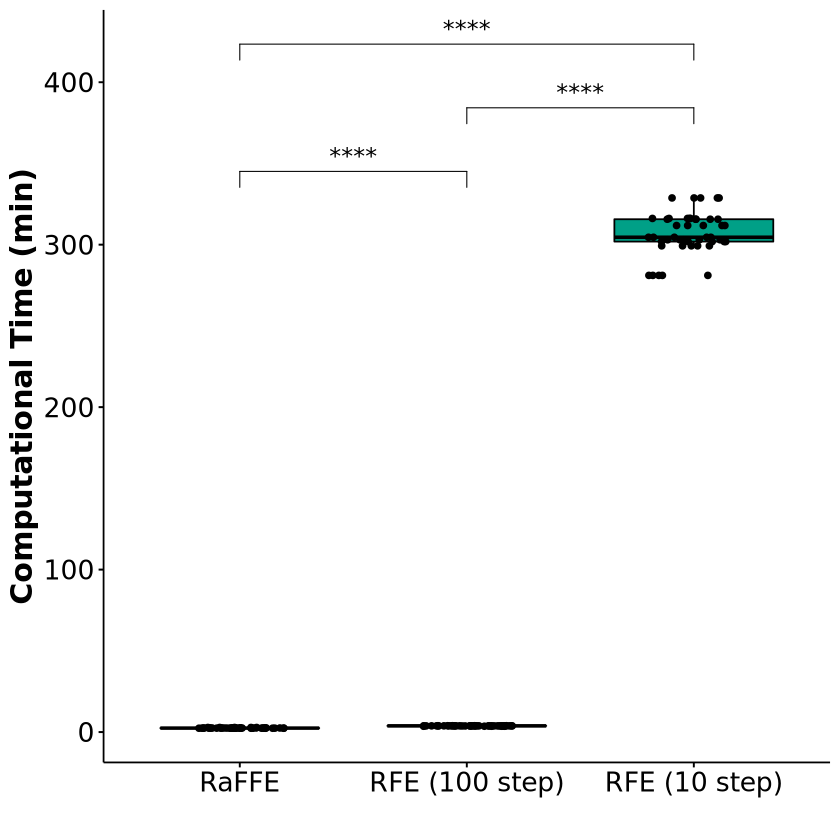

In [5]:
bxp_cpu1 = ggboxplot(dft, x='model', y='cpu', ncol=1, fill="model", 
                    palette="npg", outlier.shape=NA, add='jitter', 
                    xlab='', ylab='Computational Time (min)', 
                    legend='') + 
        stat_compare_means(comparisons = my_comparisons, 
                           aes(label = ..p.signif..), 
                           method = "t.test", size=5) + 
        font("xylab", size = 18, face='bold') + font("xy.text", size = 16)
bxp_cpu1

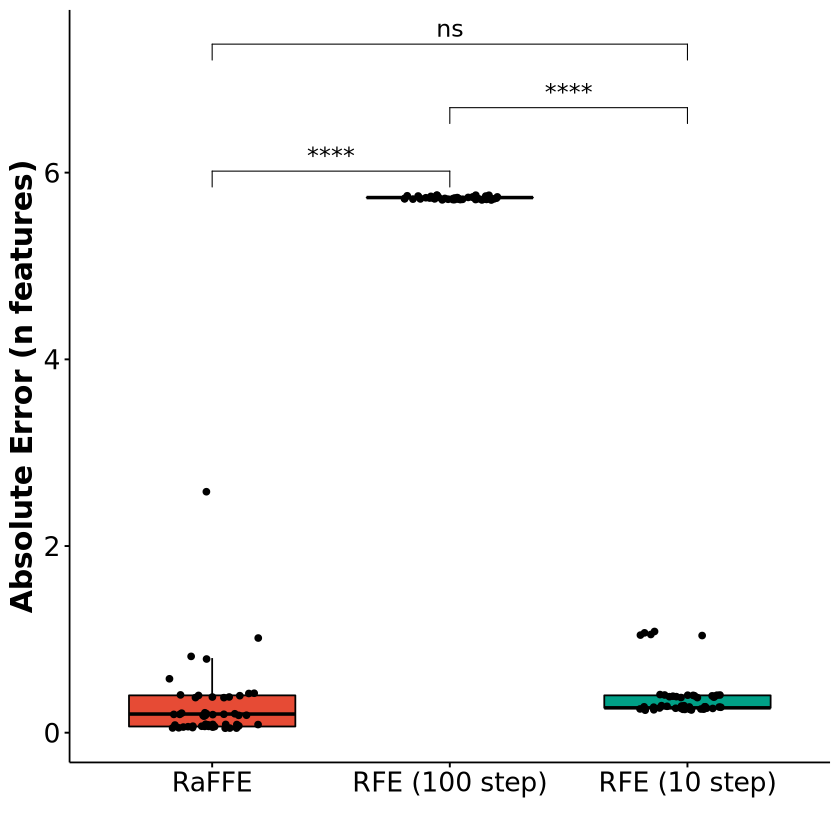

In [6]:
bxp_err1 = ggboxplot(dft, x='model', y='abs_err', ncol=1, fill="model", 
                    palette="npg", outlier.shape=NA, add='jitter', 
                    xlab='', ylab='Absolute Error (n features)', 
                    legend='') + 
        stat_compare_means(comparisons = my_comparisons, 
                           aes(label = ..p.signif..), 
                           method = "t.test", size=5) + 
        font("xylab", size = 18, face='bold') + font("xy.text", size = 16)
bxp_err1

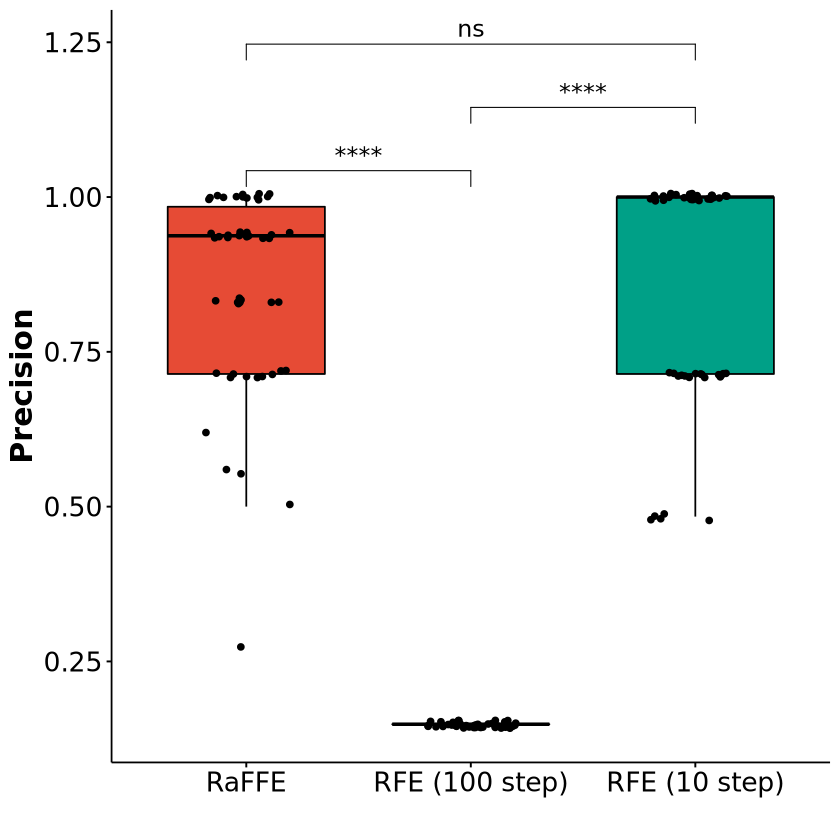

In [7]:
bxp_pre1 = ggboxplot(dft, x='model', y='precision', ncol=1, fill="model", 
                    palette="npg", outlier.shape=NA, add='jitter', 
                    xlab='', ylab='Precision', 
                    legend='') + 
        stat_compare_means(comparisons = my_comparisons, 
                           aes(label = ..p.signif..), 
                           method = "t.test", size=5) + 
        font("xylab", size = 18, face='bold') + font("xy.text", size = 16)
bxp_pre1

In [8]:
cla = ggarrange(bxp_acc1, bxp_cpu1, bxp_err1, ncol=1)
cla = annotate_figure(cla, bottom=text_grob("Classification", size=20, face='bold', hjust=0.35))

save_ggplots('classification_simu', cla, 7, 15)

## Regression

In [9]:
pred_features = 10
rfecv10 = data.table::fread('../../_m/regression_simu/rfecv_results_10_step.txt') %>% 
    select(-V1) %>% 
    pivot_longer(-c(n_features, seed, best_n, cpu_total), names_to='fold', values_to='score') %>%
    mutate(fold=str_replace(fold, 'Fold_', '')) %>% 
    group_by(seed) %>% filter(n_features %in% best_n) %>% 
    mutate(abs_err=abs(pred_features - n_features) / pred_features, model="RFE (10 step)") %>% 
    select(seed, n_features, cpu_total, score, abs_err, model) %>% 
    filter(n_features < 102) # drop outliers
rfecv100 = data.table::fread('../../_m/regression_simu/rfecv_results_100_step.txt') %>% 
    select(-V1) %>% 
    pivot_longer(-c(n_features, seed, best_n, cpu_total), names_to='fold', values_to='score') %>%
    mutate(fold=str_replace(fold, 'Fold_', '')) %>% 
    group_by(seed) %>% filter(n_features %in% best_n) %>% 
    mutate(abs_err=abs(pred_features - n_features) / pred_features, model="RFE (100 step)") %>% 
    select(seed, n_features, cpu_total, score, abs_err, model) %>% 
    filter(n_features < 102) # drop outliers
raffe = data.table::fread('../../_m/regression_simu/raffe_results.txt') %>% 
    rename(fold=index) %>% select(-V1) %>% group_by(seed) %>% 
    mutate(abs_err=abs(pred_features - n_features) / pred_features, model="RaFFE") %>% 
    select(seed, n_features, test_r2, cpu_total, abs_err, model) %>% 
    rename(score=test_r2)

dft = bind_rows(raffe, rfecv100, rfecv10) %>% mutate(cpu=cpu_total/60)
dft %>% head(2)

seed,n_features,score,cpu_total,abs_err,model,cpu
<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,8,0.8378946,158.6436,0.2,RaFFE,2.64406
1,6,0.7461280,158.6436,0.4,RaFFE,2.64406


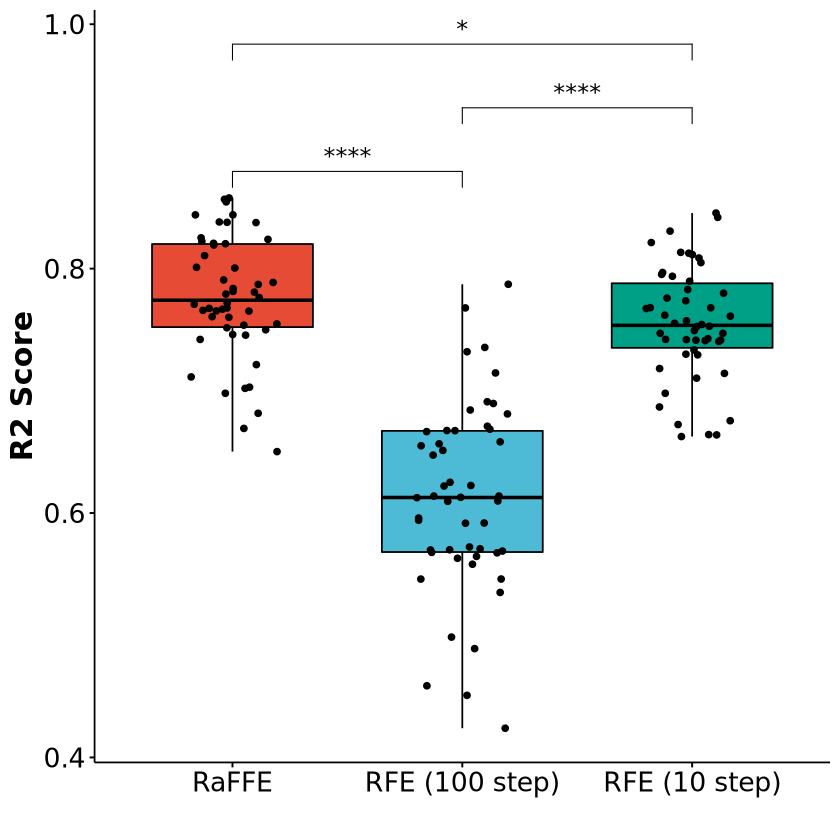

In [10]:
my_comparisons <- list( c("RaFFE", "RFE (100 step)"), 
                       c("RFE (100 step)", "RFE (10 step)"), 
                       c("RaFFE", "RFE (10 step)") )
# Add pairwise comparisons p-value
bxp_acc1 = ggboxplot(dft, x='model', y='score', ncol=1, fill="model", 
                    palette="npg", outlier.shape=NA, add='jitter', 
                    xlab='', ylab='R2 Score', legend='') + 
        stat_compare_means(comparisons = my_comparisons, 
                           aes(label = ..p.signif..), 
                           method = "t.test", size=5) + 
        font("xylab", size = 18, face='bold') + font("xy.text", size = 16)
bxp_acc1

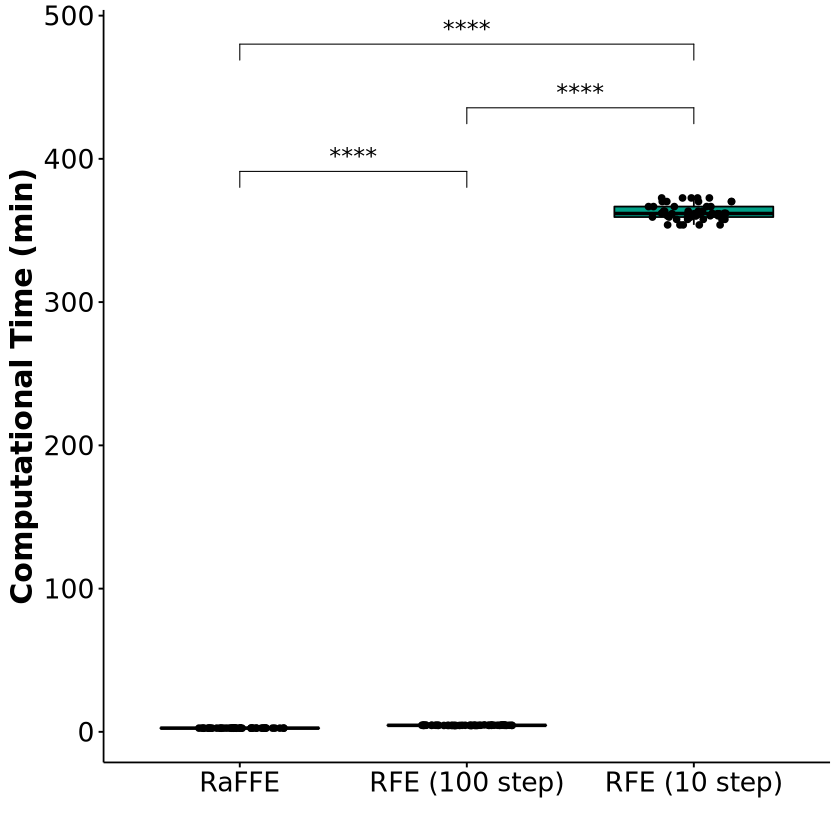

In [11]:
bxp_cpu1 = ggboxplot(dft, x='model', y='cpu', ncol=1, fill="model", 
                    palette="npg", outlier.shape=NA, add='jitter', 
                    xlab='', ylab='Computational Time (min)', 
                    legend='') + 
        stat_compare_means(comparisons = my_comparisons, 
                           aes(label = ..p.signif..), 
                           method = "t.test", size=5) + 
        font("xylab", size = 18, face='bold') + font("xy.text", size = 16)
bxp_cpu1

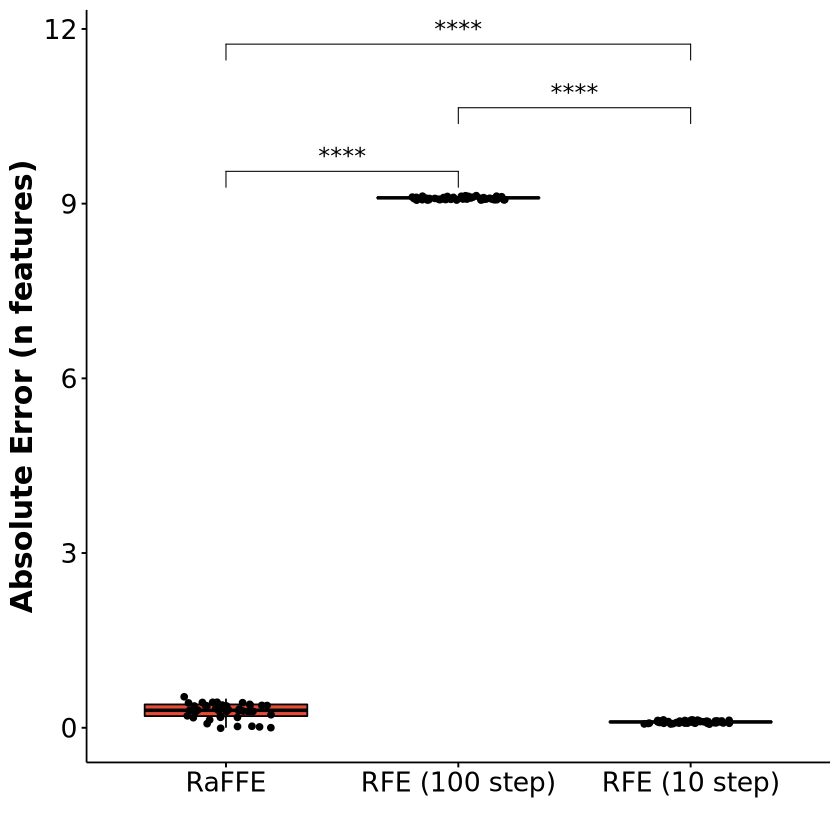

In [12]:
bxp_err1 = ggboxplot(dft, x='model', y='abs_err', ncol=1, fill="model", 
                    palette="npg", outlier.shape=NA, add='jitter', 
                    xlab='', ylab='Absolute Error (n features)', 
                    legend='') + 
        stat_compare_means(comparisons = my_comparisons, 
                           aes(label = ..p.signif..), size=5) + 
        font("xylab", size = 18, face='bold') + font("xy.text", size = 16)
bxp_err1

In [13]:
regr = ggarrange(bxp_acc1, bxp_cpu1, bxp_err1, ncol=1)
regr = annotate_figure(regr, bottom=text_grob("Regression", size=20, face='bold', hjust=0.35))

save_ggplots('regression_simu', regr, 7, 15)

## Final figure

In [14]:
figure = ggarrange(cla, regr, ncol=2)
save_ggplots('simulation', figure, 14, 15)

In [ ]:
print("Reproducibility Information:")
Sys.time()
proc.time()
options(width=120)
sessioninfo::session_info()